In [ ]:
# ! pip install catboost
# ! pip install featuretools

# ! pip install ipywidgets

# Методы валидации

In [2]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np

warnings.filterwarnings('ignore')

In [9]:
def download_adult():
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
    column_names = [
        'age', 'workclass', 'fnlwgt', 'education', 'education-num',
        'marital-status', 'occupation', 'relationship', 'race', 'sex',
        'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
    ]
    adult_df = pd.read_csv(url, names = column_names, sep=',\s')
    return adult_df

data = download_adult()
print(data.shape)
data.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# 1

### Удерживающая проверка (Hold-Out CV): датасет делится на два набора: для обучения и для тестирования. Модель обучается на тренировочном наборе, а затем оценивается на тестовом.
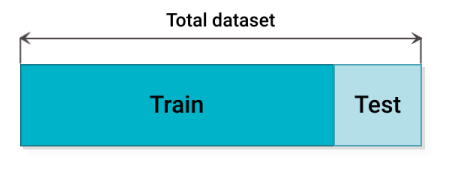

In [24]:
adult_df = data.copy()

X = adult_df.drop(['income'], axis=1)
y = (adult_df['income']=='>50K').astype(int)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [27]:
data.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [28]:
cat_features = ['workclass', 'education', 'marital-status', 'occupation',
                                                            'relationship', 'race', 'sex', 'native-country']

train_pool = Pool(data = X_train, label = y_train, cat_features = cat_features)

test_pool = Pool(data = X_test, label = y_test, cat_features = cat_features)

In [33]:
model = CatBoostClassifier(random_state=123, depth=2, eval_metric='AUC', verbose=0)
model.fit(train_pool, eval_set = test_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [36]:
model.predict_proba(test_pool)[:, 1]

array([0.00833042, 0.51879433, 0.62051383, ..., 0.00878571, 0.56864122,
       0.99647341])

In [39]:
y_pred_proba_test = model.predict_proba(test_pool)[:, 1]
auc_test = roc_auc_score(y_test, y_pred_proba_test)

In [40]:
y_pred_proba_train = model.predict_proba(train_pool)[:, 1]
auc_train = roc_auc_score(y_train, y_pred_proba_train)

In [41]:
auc_test, auc_train

(0.9245772242211552, 0.9318012970683213)

# 2
### k-блочная перекрестная проверка (k-Fold CV): в этом типе проверки набор данных делится на k подмножеств одинакового размера. Модель обучается k раз и каждый раз использует другое подмножество в качестве набора для тестирования и оставшиеся подмножества в качестве набора для обучения.

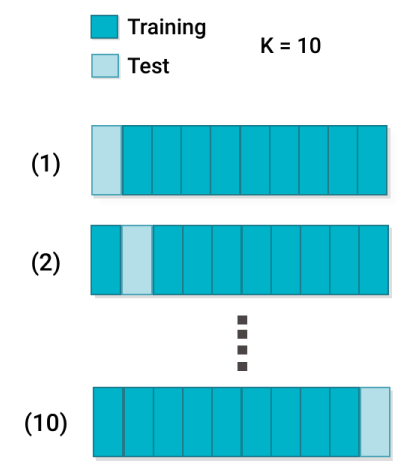

In [47]:
train_pool = Pool(data = X, label = y, cat_features = cat_features)

In [49]:
from sklearn.model_selection import cross_val_score

model = CatBoostClassifier(random_state=123, depth=2,iterations=100, eval_metric='AUC', verbose=0, cat_features=cat_features)

scores = cross_val_score(model, X,y, cv=10, scoring='roc_auc')

In [46]:
scores.mean(), scores.std()

(0.9202329047439737, 0.003923059403007608)

# 3

### Стратифицированный метод k-Fold проверки (Stratified k-Fold cross-validation) — это разновидность k-Fold CV, разработанная для эффективной работы в случаях дисбаланса классов. Например, в наборе данных о ценах на наручные часы может быть большее количество наручных часов в категории "Люкс".

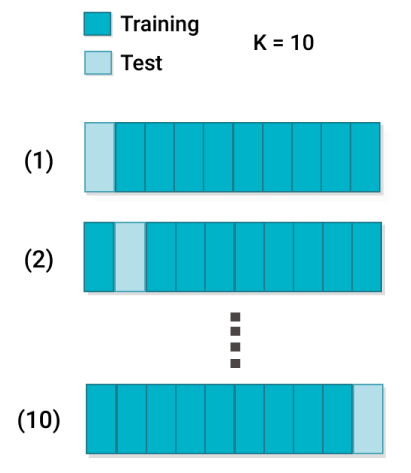

In [53]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10)

scores = cross_val_score(model,X,y, cv=skf, scoring='roc_auc')
scores.mean(), scores.std()

# 4
### Перекрестная проверка с исключением одного (Leave-One-Out Cross Validation – LOOCV): это особый случай k-Fold, где k равно количеству экземпляров в наборе данных. В этом случае каждый экземпляр используется как тестовый набор один раз.
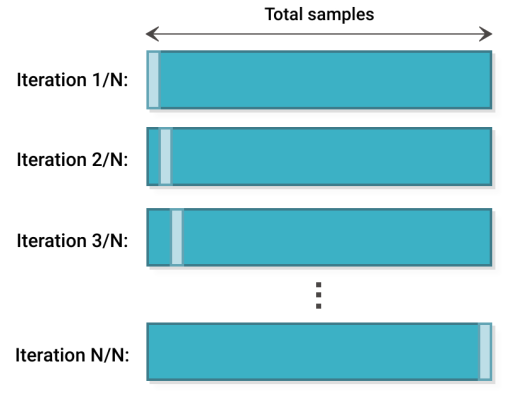

In [ ]:
X=df2.drop(labels=[target], axis=1)
y=df2[target]

In [58]:
# from sklearn.model_selection import LeaveOneOut

# loo = LeaveOneOut(n_splits=10)

# scores = cross_val_score(model,X,y, cv=loo, scoring='roc_auc',n_jobs=-1)
# scores.mean(), scores.std()

(32561, 14)

# 5
### Кросс-валидация Временных рядов или Out of time валидация. Выполняется на скользящей основе, т. е. начиная с небольшого подмножества данных в целях обучения, и дальнейшего прогнозирования будущих значений.
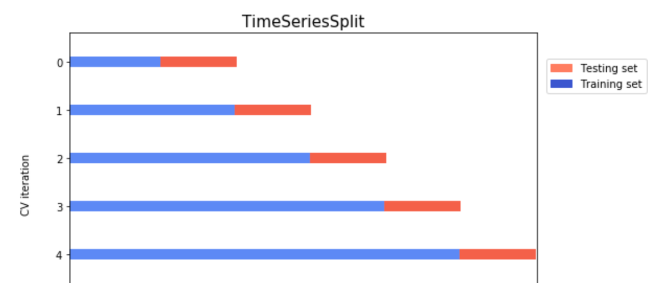

In [74]:
random_dates = pd.to_datetime(np.random.choice(pd.date_range('2018-01-01', '2024-12-31'), size=len(X)))

In [75]:
X['random_date'] = random_dates

In [78]:
X_train = X[X['random_date'].dt.year<2022]
X_test = X[X['random_date'].dt.year>=2022]
y_train = y[X['random_date'].dt.year<2022]
y_test = y[X['random_date'].dt.year>=2022]

In [79]:
cat_features = ['workclass', 'education', 'marital-status', 'occupation',
                                                            'relationship', 'race', 'sex', 'native-country']

train_pool = Pool(data = X_train, label = y_train, cat_features = cat_features)

test_pool = Pool(data = X_test, label = y_test, cat_features = cat_features)

model = CatBoostClassifier(random_state=123, depth=2, eval_metric='AUC', verbose=0)
model.fit(train_pool, eval_set = test_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Домашняя работа

# 📊 Задание по методам валидации в машинном обучении

## 1. Загрузка и предобработка данных
- 📥 **Загрузите набор данных** Bank Customer Churn Prediction и обработайте пропуски.
- 🔄 **Разделите данные на признаки (X) и целевую переменную (y).**
- 📈 **Выведите корреляционную сортированную таблицу** признаков и таргета для определения самых важных признаков, которые влияют на целевую переменную (либо в виде сортированного графика).
- 📊 **Выведите распределение целевой переменной в процентном соотношении.**

---

## 2. Удерживающая проверка (Hold-Out CV)
- ✂️ **Разделите данные на обучающую и тестовую выборки** в соотношении 80/20.
- 🧠 **Обучите модель** CatBoostClassifier с использованием обучающей выборки.
- 📊 **Оцените её производительность** на тестовой выборке, используя метрику AUC.

---

## 3. k-блочная перекрестная проверка (k-Fold CV)
- 🔁 **Реализуйте k-Fold перекрестную проверку** с использованием 5 блоков.
- 📊 **Вычислите среднее значение AUC** для всех блоков.

---

## 4. Стратифицированный k-Fold CV
- ⚖️ **Выполните стратифицированную k-Fold перекрестную проверку**.
- 🔍 **Сравните результаты** со стандартной k-Fold проверкой.
- 📝 **Объясните, в чем преимущество стратифицированного подхода.**

---

## 5. Перекрестная проверка с исключением одного (LOOCV)
- 🔄 **Реализуйте метод LOOCV**.
- 📊 **Сравните полученные результаты** с предыдущими методами. Если алгоритм работает долго, попробуйте сократить количество подаваемых строк.

---

## 6. Подготовка сравнительной таблицы
- 📊 **Подготовьте сравнительную таблицу для 4 методов валидации точности модели** (type of CV, std, mean).

---

## 7. Задание на доп балл
- 🏆 **Выведите таблицу с метриками** для порогов отсечения 0.05, 0.1, 0.15, 0.25, 0.3 для положительного класса (Только для Hold-Out CV).

---

**PS:** Качество модели необходимо рассчитать не только по метрике AUC, но и по 3 другим метрикам на ваш выбор для пунктов 2-5.

# Дополнительные материалы

https://habr.com/ru/companies/otus/articles/809147/

https://medium.com/data-and-beyond/master-the-power-of-optuna-a-step-by-step-guide-ed43500e9b95